In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from ML.segmentation.utils.file_reader import FileReader
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
file_reader = FileReader("../data")
colors = px.colors.qualitative.Plotly

In [3]:
## SAVE IMAGE DATA 
drsbru_post = file_reader.get_data_file_paths("drsbru", "post") 
drsbru_post_pm = file_reader.get_data_file_paths("drsbru", "post_pm") 
drsprg_post = file_reader.get_data_file_paths("drsprg", "post") 
drsprg_post2 = file_reader.get_data_file_paths("drsprg", "post2") 
drsprg_ant = file_reader.get_data_file_paths("drsprg", "ant") 
drsprg_ant2 = file_reader.get_data_file_paths("drsprg", "ant2")
drsprg_flood_ant = file_reader.get_data_file_paths("drsprg", "flood_ant")  
drsprg_flood_post = file_reader.get_data_file_paths("drsprg", "flood_post")  


variable_map = {
    "drsprg_post": drsprg_post,
    "drsprg_post2": drsprg_post2,
    "drsprg_ant": drsprg_ant,
    "drsprg_ant2": drsprg_ant2,
    "drsprg_flood_ant": drsprg_flood_ant,
    "drsprg_flood_post": drsprg_flood_post,
    "drsbru_post": drsbru_post,
    "drsbru_post_pm": drsbru_post_pm,
}

image_data = []

for var_name, file_list in variable_map.items():
    for file_path in file_list:
        try:
            dicom_img = pydicom.dcmread(file_path)
            height = dicom_img.Rows
            width = dicom_img.Columns
            frames = dicom_img.NumberOfFrames
            patient = dicom_img.PatientName
            study_id = dicom_img.StudyID
            description = dicom_img.SeriesDescription
            if hasattr(dicom_img, "PhaseInformationSequence"):
                phase_info_seq = dicom_img.PhaseInformationSequence  
                first_phase = phase_info_seq[0]
                if hasattr(first_phase, "ActualFrameDuration"):
                    frame_duration = int(first_phase.ActualFrameDuration)
            filename = Path(file_path).name
            
            duration = frames * frame_duration / 1000
            image_data.append([filename, patient, var_name, study_id, width, height, frames, frame_duration, duration, description])
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

df = pd.DataFrame(image_data, columns=["Filename", "Patient ID", "Group ID", "Study ID", "Width", "Height", "Frames", "Frame Duration (ms)", "Total Duration (s)",  "Description"])

df.to_csv("../data/labels/image_data.csv", index=False)

In [4]:
drsbru_ckd = pd.read_csv("../data/labels/drsbru.csv")
drsprg_ckd = pd.read_csv("../data/labels/drsprg.csv")
drsprg_patient_data = pd.read_csv("../data/labels/drsprg_patient_data.csv")
drsbru_patient_data = pd.read_csv("../data/labels/drsbru_patient_data.csv")

In [5]:
column_mapping = {
    "study name": "STUDY NAME",
    "gender": "GENDER",
    "age yrs": "AGE",
}

drsbru_patient_data.rename(columns=column_mapping, inplace=True)
drsbru_patient_data["AGE"] = np.floor(drsbru_patient_data["AGE"]).astype(int) 
drsbru_patient_data["GENDER"] = drsbru_patient_data["GENDER"].str.upper()
drsbru_ckd["STUDY NAME"] = drsbru_ckd["STUDY NAME"].str.strip()
drsprg_ckd["STUDY NAME"] = drsprg_ckd["STUDY NAME"].str.strip()

drsbru_merged = pd.merge(drsbru_patient_data, drsbru_ckd[["STUDY NAME", "CKD"]], how="inner", on="STUDY NAME")
drsprg_merged = pd.merge(drsprg_patient_data, drsprg_ckd[["STUDY NAME", "CKD"]], how="inner", on="STUDY NAME")

combined_df = pd.concat([drsbru_merged[["STUDY NAME", "GENDER", "AGE", "CKD"]], drsprg_merged[["STUDY NAME", "GENDER", "AGE", "CKD"]]], ignore_index=True)

combined_df["CKD BOOLEAN"] = combined_df["CKD"].apply(lambda x: 1 if x >= 3 else 0 if pd.notna(x) else np.nan) # Deepseek

combined_df["GENDER"] = combined_df["GENDER"].replace({"M": "Male", "F": "Female"})
bin_labels = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-45", "45-49", "50-54", "54-59", "60-64", "65-69", "70+"]
combined_df["AGE GROUP"] = pd.cut(combined_df["AGE"], bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,100], labels=bin_labels, right=False)

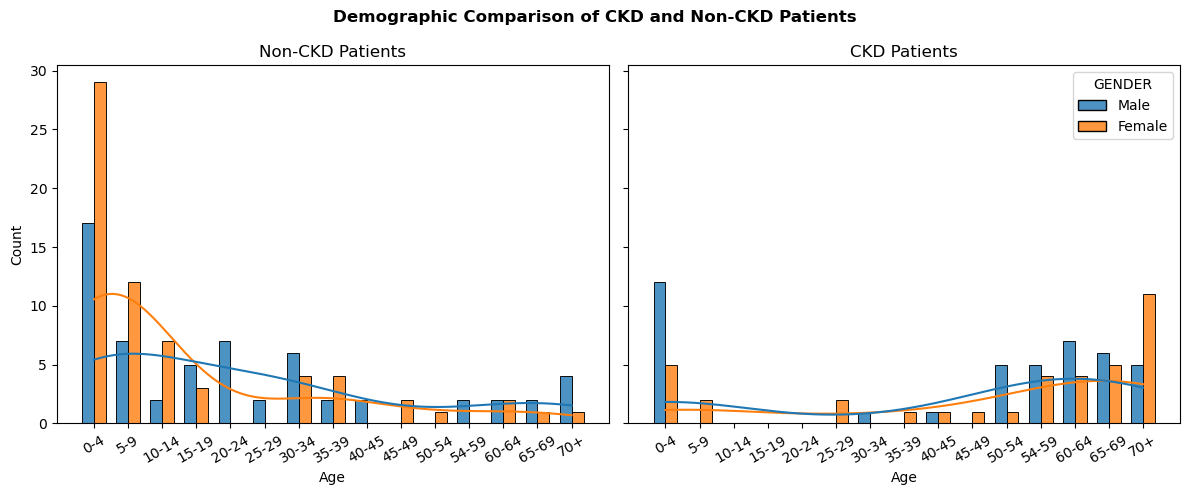

In [6]:
#sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"}) #eller whitegrid/darkgrid?

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns
sns.set_style()
sns.histplot(combined_df[combined_df["CKD BOOLEAN"] == 0], x="AGE GROUP", hue="GENDER", kde=True, alpha=0.8, shrink=0.70, multiple="dodge", edgecolor="black", ax=axes[0], legend=False)
sns.histplot(combined_df[combined_df["CKD BOOLEAN"] == 1], x="AGE GROUP", hue="GENDER", kde=True, alpha=0.8, shrink=0.70, multiple="dodge", edgecolor="black", ax=axes[1])

fig.suptitle("Demographic Comparison of CKD and Non-CKD Patients", fontweight="bold")
axes[0].set_title("Non-CKD Patients")
axes[0].set_xlabel("Age")
axes[0].tick_params(axis='x', rotation=30)  

axes[1].set_title("CKD Patients")
axes[1].set_xlabel("Age")
axes[1].tick_params(axis='x', rotation=30) 

plt.tight_layout()
plt.show()

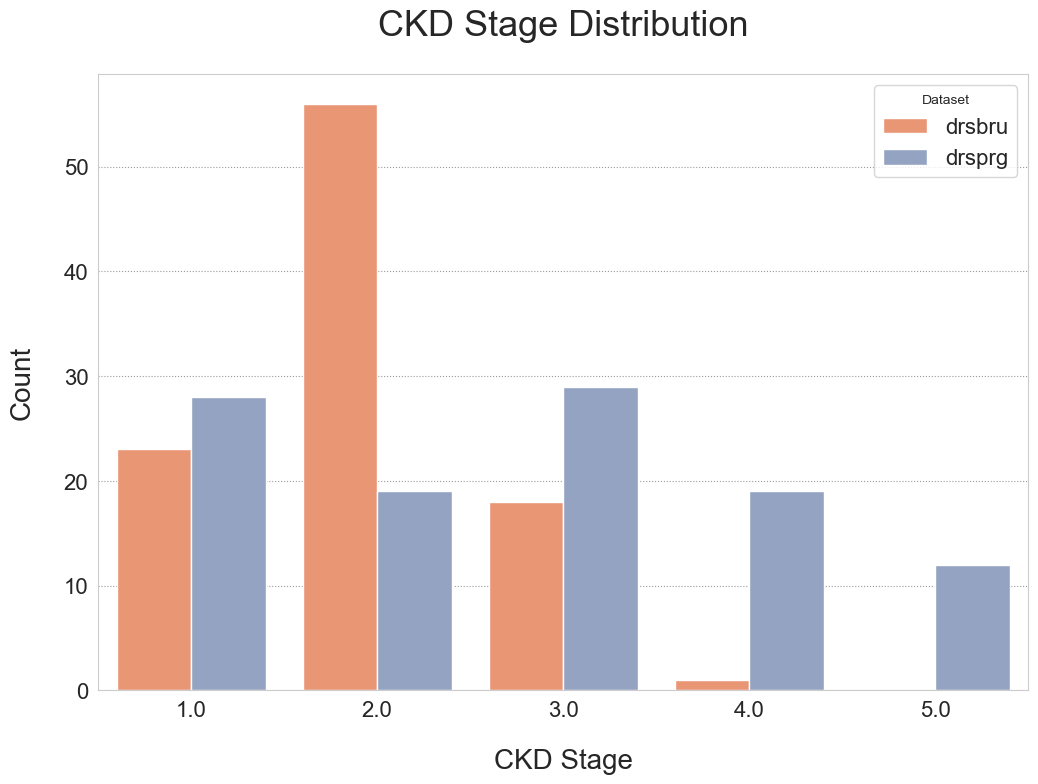

In [8]:

sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"}) #eller whitegrid/darkgrid?

drsbru_counts = drsbru_merged["CKD"].value_counts().sort_index()
drsprg_counts = drsprg_merged["CKD"].value_counts().sort_index()

# Sample colors from a Seaborn color palette
colors = sns.color_palette("Set2")  # Try "Set1", "Pastel", "Dark2", etc.

# Convert data to a Pandas DataFrame for Seaborn
df_drsbru = pd.DataFrame({"CKD Stage": drsbru_counts.index, "Count": drsbru_counts.values, "Dataset": "drsbru"})
df_drsprg = pd.DataFrame({"CKD Stage": drsprg_counts.index, "Count": drsprg_counts.values, "Dataset": "drsprg"})

# Concatenate both datasets for Seaborn's long-form data format
df = pd.concat([df_drsbru, df_drsprg])

# Plot using Seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size

sns.barplot(
    data=df, 
    x="CKD Stage", 
    y="Count", 
    hue="Dataset", 
    palette=[colors[1], colors[2]]  # Apply custom colors
)

# Customize labels
plt.title("CKD Stage Distribution", fontsize=26, y=1.05)
plt.xlabel("CKD Stage", fontsize=20, labelpad=20)
plt.ylabel("Count", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)  # Rotate x-axis labels for clarity
plt.yticks(fontsize=16)
plt.legend(title="Dataset", fontsize=16)


plt.show()


C:\Users\mlovh\AppData\Local\Temp\ipykernel_13036\3816680772.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0, 0.5, 'Age')

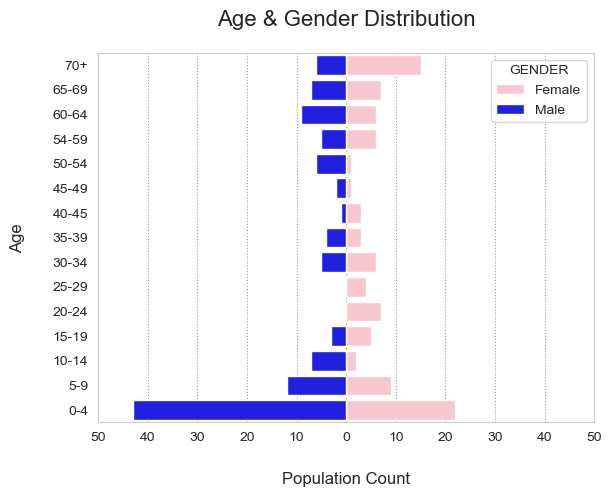

In [21]:
grouped_df = combined_df.groupby(["AGE GROUP","GENDER"]).size().reset_index(name="Count")
grouped_df.loc[grouped_df["GENDER"] == "Male", "Count"] = -grouped_df.loc[grouped_df["GENDER"] == "Male", "Count"] # deepseek
max_count = grouped_df["Count"].abs().max()

sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"}) #eller whitegrid/darkgrid?
#https://stackoverflow.com/questions/63619776/population-pyramid-with-python-and-seaborn
sns.barplot(data=grouped_df, x="Count", y="AGE GROUP",
            hue="GENDER", orient='horizontal',
            dodge=False, palette={"Male": "blue", "Female": "pink"})

plt.xlim(-max_count, max_count)
tick_values = plt.xticks()[0]  # Get current tick positions
plt.xticks(tick_values, [f"{int(abs(tick))}" for tick in tick_values])
plt.gca().invert_yaxis()

plt.title("Age & Gender Distribution", fontsize=16, y=1.05)
plt.xlabel("Population Count", fontsize=12, labelpad=20)
plt.ylabel("Age", fontsize=12, labelpad=20)


In [25]:
#CHAT 
import plotly.graph_objects as go
import pandas as pd

# Find the absolute maximum count for symmetry
max_count = np.ceil(grouped_df["Count"].abs().max() / 10) * 10

tick_values = list(range(-int(max_count), int(max_count) + 1, 10))
print(tick_values)
# Create the figure
fig = go.Figure()

# Add Male (left side, negative values)
fig.add_trace(go.Bar(
    y=grouped_df[grouped_df["GENDER"] == "Male"]["AGE GROUP"],
    x=grouped_df[grouped_df["GENDER"] == "Male"]["Count"],
    name="Male",
    orientation="h",
    marker=dict(color="blue"),
    #text=binned_df[binned_df["GENDER"] == "M"]["Count"].abs(),  # Show positive values
    textposition="outside"
))

# Add Female (right side, positive values)
fig.add_trace(go.Bar(
    y=grouped_df[grouped_df["GENDER"] == "Female"]["AGE GROUP"],
    x=grouped_df[grouped_df["GENDER"] == "Female"]["Count"],
    name="Female",
    orientation="h",
    marker=dict(color="pink"),
    #text=binned_df[binned_df["GENDER"] == "F"]["Count"],  # Show positive values
    textposition="outside"
))

# Update layout for symmetry & styling
fig.update_layout(
    title="Age & Gender Distribution",
    title_font=dict(size=18),
    xaxis=dict(
        tickmode="array",
        tickvals=tick_values,  # Symmetrical tick values
        ticktext=[str(abs(x)) for x in tick_values],  # Remove negative labels
        title="Population Count",
        range=[-max_count, max_count]
    ),
    yaxis=dict(title="Age"),  # Flip y-axis
    barmode="relative",  # Ensures bars are aligned properly
    template="plotly_white",  # White grid background
    legend=dict(title="Gender"),
    bargap=0,  # Removes padding between bar
    width=800,
)

# Show the figure
fig.show()


[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]


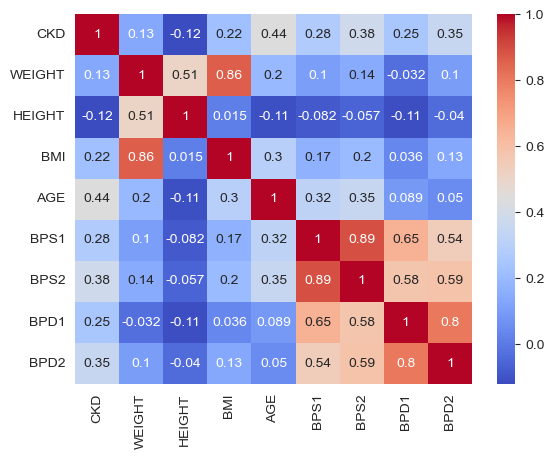

In [26]:
sns.heatmap(drsprg_merged[["CKD", "WEIGHT", "HEIGHT", "BMI", "AGE", "BPS1", "BPS2", "BPD1", "BPD2"]].corr(), annot=True, cmap="coolwarm")
plt.show()

In [34]:
#CHAT

import plotly.express as px
import pandas as pd

drsprg_corr = drsprg_merged.copy()
drsprg_corr["GENDER"] = drsprg_corr["GENDER"].replace({"M": 1, "F": 0})
# Compute the correlation matrix
corr_matrix = drsprg_corr[["CKD", "GENDER", "WEIGHT", "HEIGHT", "BMI", "AGE", "BPS1", "BPS2", "BPD1", "BPD2"]].corr() #"BSA - H", "BSA - D"

# Convert the correlation matrix into a long format
corr_matrix_long = corr_matrix.stack().reset_index()
corr_matrix_long.columns = ["Variable1", "Variable2", "Correlation"]

# Create the heatmap
fig = px.imshow(corr_matrix.values,
                x=corr_matrix.columns,
                y=corr_matrix.index,
                color_continuous_scale='RdBu_r'
)
fig.update_layout(
    width=600,
    height=600
)
# Add text annotations
fig.update_traces(text=corr_matrix.values.round(2), texttemplate="%{text}")

# Show the heatmap
fig.show()


C:\Users\mlovh\AppData\Local\Temp\ipykernel_13036\219913699.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

